In [1]:
# 这里是专门用来debug的，查看每个模块运行的时间（除了数据创建模块）
import sys
sys.path.append("..")
import h5py
import numpy as np
import faiss
import os
import time
from config import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

In [2]:
# 想记录每一次实验，每个细节包括检索，数据合并的时间，用一个字典存储
Times={}

In [3]:
# 单个数据处理
def get_test_data_QPS(data_choice:str='glove',dim:int=25,number:int=100,k:int=10):#这里定义一个number是为了选取测试集数量，默认是100个
    start_time = time.time()
    data_name= data_expand_info[data_choice][dim] # 这里是为了方便创建文件夹和数据库文件名，方便识别
    glove_file_path = f"../data_expand/{data_name}.hdf5"
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    glove_test = glove_hdf['test'][:number]# 获取测试查询数据
    if data_choice=='glove':
        faiss.normalize_L2(glove_test)# glove数据采用的angular距离，首先需要进行归一化,然后再进行faiss.METRIC_L2
    glove_neighbors = glove_hdf['neighbors'][:number,:k]# 获取测试数据集
    glove_distances = glove_hdf['distances'][:number,:k]# 获取测试数据集
    end_time = time.time()
    time_get_test_data = end_time - start_time
    return glove_test,glove_neighbors,glove_distances,time_get_test_data


In [4]:
# 获取对应的索引
def get_id(data_choice:str='glove',n_piece:int=5,dim:int=25):
    start_time = time.time()
    data_name= data_expand_info[data_choice][dim]
    glove_file_path = f"../data_expand/{data_name}.hdf5"# 数据地址，hdf5格式
    glove_hdf = h5py.File(glove_file_path, "r")# 读取数据
    length_all = len(glove_hdf['train'])# 获取数据的总长度  
    cut_point=int(length_all/n_piece)# 获取切分点,int是向下取整
    id_dict={}# 这里用字典来存取每一段对应的索引
    for i in range(n_piece):
        keys='npiece_'+str(i+1)
        if i+1 == n_piece:
            id=list(range(i*cut_point,length_all))
            id=np.array(id)
            id_dict[keys]=id
        else:
            id=list(range(i*cut_point,(i+1)*cut_point))
            id=np.array(id)
            id_dict[keys]=id
    end_time = time.time()
    time_get_id = end_time - start_time
    return id_dict,time_get_id

# 创建存储数据的文件
def create_index_folder_choice(data_name:str,n_piece:int=5,index_style:str='HNSW',M:int=16,efConstruction:int=500)->str:#这里的n_piece需要与data_piece函数中的n_piece一致
    folder_path = f"../index_{index_style}_QPS/{data_name}_n{n_piece}_M{M}_efcon{efConstruction}"
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        # 不存在时创建文件夹
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 不存在，已创建。")
    else:
        print(f"文件夹 '{folder_path}' 已经存在。")
    return folder_path

In [5]:
# 多个数据之间的合并
def combine_list(data: list, ids: list, k: int = 10):
    # 将每个元素和对应ID放在一个元组中
    combined_tuples = [(element, id_val) for element, id_val in zip(data, ids)]
    # 对拼接后的元组列表按照元素排序，sorted是从小到大排序的，正好取前k个即可
    sorted_combined_tuples = sorted(combined_tuples, key=lambda x: x[0])
    # 输出排序后的元素和对应的ID列表
    sorted_elements = [element[0] for element in sorted_combined_tuples]
    sorted_ids = [element[1] for element in sorted_combined_tuples]
    return sorted_elements[:k], sorted_ids[:k]

In [6]:
# 获取搜索结果
def get_search_result_HNSW_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,M:int=16,efConstruction:int=500,efsearch:int=10,k:int=10,number:int=100):# number是指定测试集的数量,要和get_test_data函数中的number一致
    # data_dict,data_name=data_piece(data_choice,n_piece,dim)
    time_list=[]# 用于获取一次实验中的耗时
    data_name= data_expand_info[data_choice][dim] 
    folder_path = create_index_folder_choice(data_name,n_piece,'HNSW',M,efConstruction)
    golve_test,_,_,time_get_test_data= get_test_data_QPS(data_choice,dim,number,k)# 这是一个双层数组，因为有这么多测试数据集
    time_list.append(time_get_test_data) # 1、记录获取测试数据的时间
    # 测试数据提取
    search_id=[]
    search_distance=[]
    id_dict,time_get_id=get_id(data_choice,n_piece,dim)
    time_list.append(time_get_id)# 2、记录获取索引的时间
    time_piece_list=[]# 3、用于记录每个分片的时间:包括最大值，最小值，总时间
    for i in range(n_piece):
        time_piece_start=time.time()
        data_key=data_name+'_M'+str(M)+'_efcon'+str(efConstruction)+'_n'+str(n_piece)+'_'+str(i+1)
        keys='npiece_'+str(i+1)
        print(f'正在处理数据集{data_key}')
        file_path = f"{folder_path}/{data_key}.index"
        index = faiss.read_index(file_path)
        # 设置搜索参数
        index.hnsw.efSearch = efsearch
        sd,sid=index.search(golve_test, k)
        id_real=id_dict[keys][sid]
        search_id.append(id_real)
        search_distance.append(sd)
        time_piece_end=time.time()
        time_piece=time_piece_end-time_piece_start
        time_piece_list.append(time_piece)
    time_piece_max=max(time_piece_list)
    time_piece_min=min(time_piece_list)
    time_piece_sum=sum(time_piece_list)
    time_list.append(time_piece_max)
    time_list.append(time_piece_min)
    time_list.append(time_piece_sum)

    time_concatenate_start=time.time()
    search_id=np.array(search_id)
    search_distance=np.array(search_distance)
    search_id=np.concatenate(search_id, axis=1)
    search_distance=np.concatenate(search_distance, axis=1)
    time_concatenate_end=time.time()
    time_concatenate=time_concatenate_end-time_concatenate_start
    time_list.append(time_concatenate) # 4、记录合并数据的时间
    # return search_id,search_distance
    # 然后进行排序操作
    test_id=[]
    test_distance=[]
    time_query_list=[] # 5、记录查询时间：最大值，最小值，总时间
    for i in range(number):
        time_query_start=time.time()
        # print(f'正在处理第{i}个测试数据')
        distance_list,id_list = combine_list(search_distance[i], search_id[i],k)
        test_id.append(id_list) 
        test_distance.append(distance_list)
        time_query_end=time.time()
        time_query=time_query_end-time_query_start
        time_query_list.append(time_query)
    time_query_max=max(time_query_list)
    time_query_min=min(time_query_list)
    time_query_sum=sum(time_query_list)
    time_list.append(time_query_max)
    time_list.append(time_query_min)
    time_list.append(time_query_sum)

    test_id=np.array(test_id)
    test_distance=np.array(test_distance)
    # all_time=time_get_test_data+time_get_id+time_piece_sum+time_concatenate+time_query_sum
    all_time=time_piece_sum
    time_list.append(all_time)
    return test_id,test_distance,time_list,all_time
# 这样计算的time_list列表中的每一个元素从索引0到9分别表示：
# time_get_test_data,time_get_id,time_piece_max,time_piece_min,time_piece_sum,time_concatenate,time_query_max,time_query_min,time_query_sum,all_time

# 计算召回率
def calculate_recall_np(test_id, ground_truth_id):
    tp = len(np.intersect1d(test_id, ground_truth_id))
    recall = tp / len(ground_truth_id) if len(ground_truth_id) != 0 else 0.0
    return recall

# 计算QPS和召回率
def get_QPS(data_choice:str='glove',n_piece:int=5,dim:int=25,M:int=16,efConstruction:int=500,efsearch:int=10,k:int=10,number:int=100):
    # glove_test,distance_true和neighbors_true暂时没用到
    _,neighbors_true,_,_=get_test_data_QPS(data_choice,dim,number,k)# 获取真实id
    test_id,_,time_list,all_time=get_search_result_HNSW_QPS(data_choice,n_piece,dim,M,efConstruction,efsearch,k,number)
    # print(test_id.shape,neighbors_true.shape)
    recall_list=[]
    for i in range(number):
        recall=calculate_recall_np(test_id[i],neighbors_true[i])
        recall_list.append(recall)
    mean_reacall=np.mean(recall_list)
    qps=number/all_time
    return mean_reacall,qps,time_list

In [7]:
# 多组实验----------------------------------------
# 进行多组实验：输出一个字典，key是data_key，value是对应的recall和qps
def get_multiple_QPS(data_choice:str='glove',dim:int=25,n_piece:list=[5],M:list=[16,64],efConstruction:list=[100,500],efsearch:list=[1,3,5,7,10,15,20,30,40,60,80,100,500],k:int=10,number:int=1000):
    npiece=n_piece
    M = M
    efConstruction=efConstruction
    efsearch=efsearch
    result_dict={}
    for i in npiece:
        for j in M:
            for e in efConstruction:
                data_name= data_expand_info[data_choice][dim] 
                data_key=data_name+'_M'+str(j)+'_efcon'+str(e)+'_n'+str(i)
                result_dict[data_key]={}
                qps=[]
                recall=[]
                for l in efsearch:
                    time_key=data_key+'_efsearch'+str(l)
                    print(i,j,e,l)
                    mean_reacall,qps_,time_list=get_QPS(data_choice,n_piece=i,dim=dim,M=j,efConstruction=e,efsearch=l,k=k,number=number)
                    qps.append(qps_)
                    recall.append(mean_reacall)
                    Times[time_key]=time_list
                result_dict[data_key]['recall']=np.array(recall)
                result_dict[data_key]['qps']=np.array(qps)
    column_names=['time_get_test_data','time_get_id','time_piece_max','time_piece_min','time_piece_sum','time_concatenate','time_query_max','time_query_min','time_query_sum','all_time']
    # 使用 from_dict() 方法创建 DataFrame
    # 将Times存储在data.csv文件中
    df = pd.DataFrame.from_dict(Times, orient='index', columns=column_names) 
    '''
    也可以用以下方式
    df = pd.DataFrame(Times).T
    df.columns = column_names
    '''
    file_name=f'debug/HNSW_QPS_k{k}.xlsx'
    df.to_excel(file_name, index_label='data_name')
    return result_dict



In [8]:
# 可视化-------------------------------------------
# 创建存储图片所需要的文件夹
def create_photo_store_qps(data_choice:str='glove',dim:int=25,faiss_style:str='HNSW')->str:
    data_name= data_expand_info[data_choice][dim]
    folder_path = f"figure/{data_name}_{faiss_style}_QPS"
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        # 不存在时创建文件夹
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 不存在，已创建。")
    else:
        print(f"文件夹 '{folder_path}' 已经存在。")
    return folder_path

def plot_multiple_lines_qps( data_dict: dict, data_choice: str = 'glove', dim: int = 25,faiss_style:str='HNSW',k:int=10):
    # 创建文件夹并确定文件路径
    data_name= data_expand_info[data_choice][dim] 
    folder_path = create_photo_store_qps(data_choice, dim,faiss_style)
    file_path = f"{folder_path}/{faiss_style}_k{k}_multiple_lines.png"
    num_lines = len(data_dict)
    # 创建图表对象
    plt.figure(figsize=(8, 5))
    # 使用seaborn颜色板
    colors = sns.color_palette("husl", num_lines)
    # 遍历每条折线图
    for i, (key, inner_dict) in enumerate(data_dict.items()):
        # 提取数据
        x_values = inner_dict['recall']
        y_values = inner_dict['qps']
        # 选择不同颜色，可以根据需要修改颜色
        # line_color = plt.cm.viridis(i / num_lines)
        line_color = colors[i]
        # 在同一个图中绘制多条折线图，并设置标签位置在图外
        sub_label=key
        plt.plot(x_values, y_values, marker='o', label=sub_label, color=line_color)
    # 添加标签和标题
    set_xlabel, set_ylabel = 'Recall', 'query per second(1/s)'
    plt.xlabel(set_xlabel)
    plt.ylabel(set_ylabel)
    plt_title=data_name+'-'+faiss_style+'-k'+str(k)+'-QPS'
    plt.title(plt_title)

    # 添加图例，并设置位置在图外
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # 保存图片
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()

5 4 100 1
文件夹 '../index_HNSW_QPS/glove-25-angular-100000_n5_M4_efcon100' 已经存在。
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_1
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_2
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_3
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_4
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_5
5 4 100 3
文件夹 '../index_HNSW_QPS/glove-25-angular-100000_n5_M4_efcon100' 已经存在。
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_1
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_2
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_3
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_4
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_5
5 4 100 5
文件夹 '../index_HNSW_QPS/glove-25-angular-100000_n5_M4_efcon100' 已经存在。
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_1
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_2
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_3
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_4
正在处理数据集glove-25-angular-100000_M4_efcon100_n5_5
5 4 100 7
文件夹 '../index_HNSW_QPS/glove-25-a

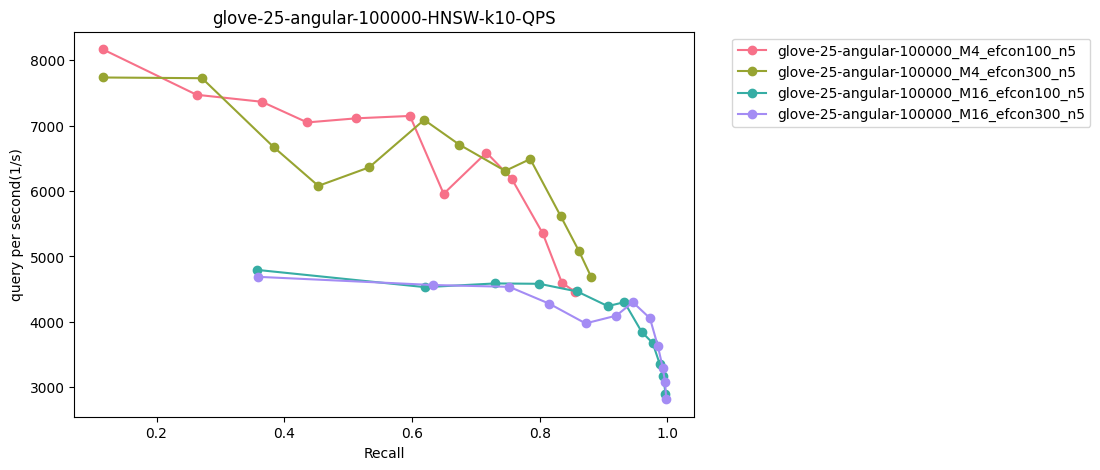

In [12]:
'''
这里主要是用来对hnsw进行debug，由于之前已经创建好了数据集，现在就不用创建了
1、冷启动的问题：没有，就是程序的不稳定性
2、我们固定分片来进行操作，取分片 n_piece=10,测试k=10000的时候，每个分片内的召回的数量对实验的影响
'''
# 创建多组实验所采用的数据集
# get_multiple_data(data_choice='glove',dim=25,n_piece=[5,10],M=[4,16,32],efConstruction=[100,300,500])

# k取10，100，1000，10000，100000进行测试
k=10
# 进行多组实验：输出一个双层字典，key是data_key，value是对应的recall和qps字典
result_dict=get_multiple_QPS(data_choice='glove',dim=25,n_piece=[5],M=[4,16],efConstruction=[100,300],efsearch=[1,3,5,7,10,15,20,30,40,60,80,100],k=k)
# result_dict=get_multiple_QPS(data_choice='glove',dim=25,n_piece=[5],M=[4],efConstruction=[300],efsearch=[1,3,5,7,10,15,20,30,40,60,80,100,500],k=k1,3,5,7,10,15,20,30,40,60,80,100,500,number=1000)

# 可视化
plot_multiple_lines_qps(result_dict, data_choice='glove', dim=25,faiss_style='HNSW',k=k)

In [10]:
# import pandas as pd

# # 创建一个示例字典
# data = {
#     'Name': ['Alice', 'Bob', 'Charlie'],
#     'Age': [25, 30, 35],
#     'City': ['New York', 'Los Angeles', 'Chicago']
# }

# # 将字典转换为 DataFrame 并转置
# df = pd.DataFrame(data).T

# # 自定义列名
# column_names = ['Personal Name', 'Personal Age', 'Personal City']

# # 重新分配列名
# df.columns = column_names

# # 将 DataFrame 保存到 CSV 文件
# df.to_csv('data.csv', index_label='Key')
